In [ ]:
# %%capture
import numpy as np
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
import pandas as pd
from sparse import COO
import h5py

from lmfit.lineshapes import gaussian

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pathlib import Path

from cosipy.response import FullDetectorResponse, DetectorResponse, ListModeResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import test_data

from histpy import Histogram
import mhealpy as hmap
from mhealpy import HealpixMap, HealpixBase
from scoords import Attitude, SpacecraftFrame

from threeML import Model, Powerlaw, Gaussian

In [ ]:
# Set initial conditions
nbins = 5
sigma_rsp = 1

### Creating example response file

In [75]:
Ei = np.linspace(507, 515, nbins)

R = np.zeros((5,5))
for i in np.arange(5):
    Z = gaussian(x=Ei[i], center=Ei, sigma=sigma_rsp)
    R[i, :] = np.round(Z / np.sum(Z), 2)

adjust = 1 - np.sum(R, axis=0)
for i in range(nbins):
    if np.abs(adjust[i]) < 0.001:
        continue
    elif np.abs(adjust[i]) - 0.01 < 0.001:
        R[i, i] += adjust[i]
    elif np.abs(adjust[i]) - 0.02 < 0.001:
        R[[i-1,i+1], i] += adjust[i] / 2
    else:
        print(i, adjust[i])
        raise

R[::-1, :]

array([[0.  , 0.  , 0.  , 0.11, 0.89],
       [0.  , 0.  , 0.11, 0.79, 0.11],
       [0.  , 0.1 , 0.78, 0.1 , 0.  ],
       [0.11, 0.79, 0.11, 0.  , 0.  ],
       [0.89, 0.11, 0.  , 0.  , 0.  ]])

In [76]:
np.sum(R, axis=0)

array([1., 1., 1., 1., 1.])

In [102]:
# TODO: How to expand bincenters to bin edges using numpy?
# Search key: np.arange(506, 517, 2)

In [77]:
h = Histogram([np.arange(4), np.arange(506, 517, 2), np.arange(506, 517, 2)], contents=np.stack([R, R, R]), labels=['NuLambda', 'Ei', 'Em'])

for axis in h.axes:
    print(f"Axis {axis.label} has {axis.nbins} bins")

h.contents

Axis NuLambda has 3 bins
Axis Ei has 5 bins
Axis Em has 5 bins


array([[[0.89, 0.11, 0.  , 0.  , 0.  ],
        [0.11, 0.79, 0.11, 0.  , 0.  ],
        [0.  , 0.1 , 0.78, 0.1 , 0.  ],
        [0.  , 0.  , 0.11, 0.79, 0.11],
        [0.  , 0.  , 0.  , 0.11, 0.89]],

       [[0.89, 0.11, 0.  , 0.  , 0.  ],
        [0.11, 0.79, 0.11, 0.  , 0.  ],
        [0.  , 0.1 , 0.78, 0.1 , 0.  ],
        [0.  , 0.  , 0.11, 0.79, 0.11],
        [0.  , 0.  , 0.  , 0.11, 0.89]],

       [[0.89, 0.11, 0.  , 0.  , 0.  ],
        [0.11, 0.79, 0.11, 0.  , 0.  ],
        [0.  , 0.1 , 0.78, 0.1 , 0.  ],
        [0.  , 0.  , 0.11, 0.79, 0.11],
        [0.  , 0.  , 0.  , 0.11, 0.89]]])

(<Axes: xlabel='Ei', ylabel='Em'>,
 <matplotlib.collections.QuadMesh at 0x2a6450d90>)

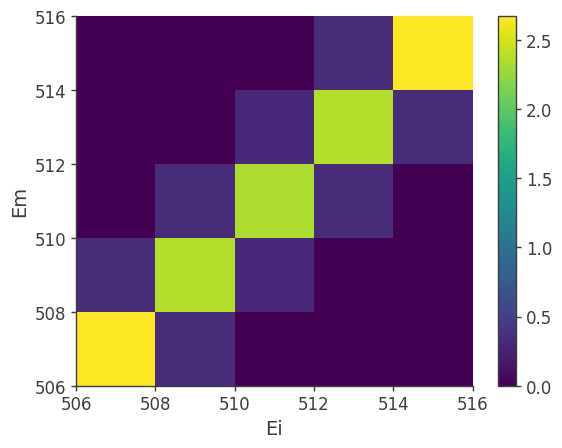

In [78]:
h.project('Ei', 'Em').draw()

In [81]:
eps_upper_limit = ((Ei[-1] - Ei[0]) / Ei[0]).round(3) / 2
eps_col_edges = np.linspace(-eps_upper_limit, eps_upper_limit, nbins+1)

In [88]:
for i in range(5):
    Em = (eps_col_edges[i]+eps_col_edges[i+1])/2 * Ei + Ei
    print(Em)
    R[i, :] = gaussian(x=Em, center=Ei, sigma=sigma_rsp)

R /= np.sum(R, axis=0)
R = np.round(R, 2)

adjust = 1 - np.sum(R, axis=0)
print(adjust)
for i in range(nbins):
    if np.abs(adjust[i]) < 0.001:
        continue
    elif np.abs(adjust[i]) - 0.01 < 0.001:
        R[2, i] += adjust[i]
    elif np.abs(adjust[i]) - 0.02 < 0.001:
        R[[1,3], i] += adjust[i] / 2
    else:
        print(i, adjust[i])
        raise

R = R.transpose(1,0)

R[::-1]

[503.7552 505.7424 507.7296 509.7168 511.704 ]
[505.3776 507.3712 509.3648 511.3584 513.352 ]
[507. 509. 511. 513. 515.]
[508.6224 510.6288 512.6352 514.6416 516.648 ]
[510.2448 512.2576 514.2704 516.2832 518.296 ]
[0.01 0.01 0.01 0.01 0.  ]


array([[0.  , 0.17, 0.66, 0.17, 0.  ],
       [0.  , 0.17, 0.66, 0.17, 0.  ],
       [0.  , 0.17, 0.66, 0.17, 0.  ],
       [0.  , 0.17, 0.66, 0.17, 0.  ],
       [0.  , 0.17, 0.66, 0.17, 0.  ]])

In [95]:
htransformed = Histogram([np.arange(4), np.arange(506, 517, 2)*u.keV, eps_col_edges], contents=np.stack([R, R, R]), unit=u.cm**2, labels=['NuLambda', 'Ei', 'eps'])

In [96]:
htransformed.write('transformed_response_example.h5', overwrite=True)
# htransformed.contents

(<Axes: xlabel='Ei [keV]', ylabel='eps'>,
 <matplotlib.collections.QuadMesh at 0x2a50e6440>)

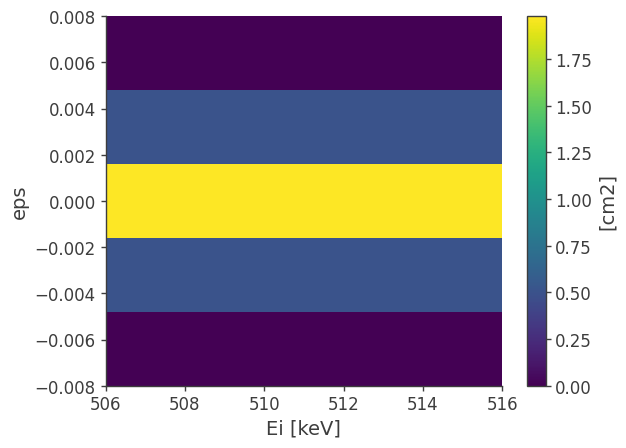

In [33]:
htransformed.project('Ei', 'eps').draw()

### Load example response

In [6]:
image_response = Histogram.open('transformed_response_example.h5')

In [98]:
dr = ListModeResponse(image_response.axes[1:],
                      contents = image_response.slice[1].contents.reshape(5,5),
                      sparse = False,
                      unit = image_response.unit)

In [100]:
Ei0 = 511.1*u.keV
Em0 = 511*u.keV
dr.get_interp_response({'Ei': Ei0, 'Em': Em0})

Bilinear interpolated value: 0.6300401095675922 cm2
Multidimensional interpolated value: 0.6300401095675922 cm2


<Quantity 0.63004011 cm2>

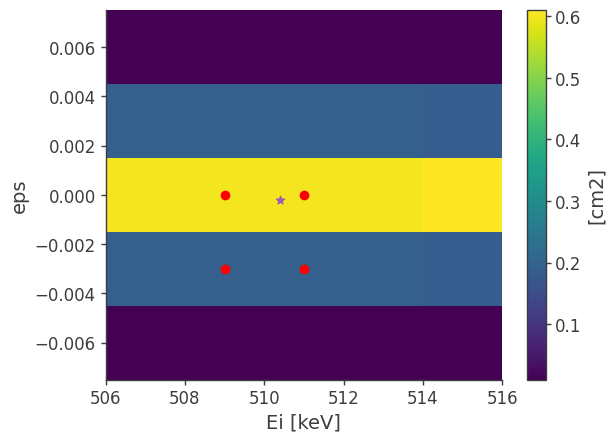

In [12]:
fig, ax = plt.subplots()
dr.draw(ax=ax)
ax.scatter(Ei0, dr.transform_Em_to_eps(Em0, Ei0), marker='*')
for e1 in dr.neighbors[0]:
    for e2 in dr.neighbors[1]:
        ax.scatter(e1, dr.transform_Em_to_eps(e2, Ei0), c='r')
plt.show()

In [118]:
mu = 511
sigma_inj = 1
bins = np.arange(506, 517, 2)

# Create model 0
model0 = np.array([0.005,0.005, 0.98, 0.005, 0.005])
print(model0)

# Create model 1
counts, bins = np.histogram(np.random.normal(loc=mu-1, scale=sigma_inj, size=10000), bins=bins)
bincenters = (bins[1:]+bins[:-1])/2 * u.keV
model1 = counts / np.sum(counts)
print(model1)

# Create model 2
counts, bins = np.histogram(np.random.normal(loc=mu, scale=sigma_inj, size=10000), bins=bins)
model2 = counts / np.sum(counts)
print(model2)

# Create model 3
counts, bins = np.histogram(np.random.normal(loc=mu+1, scale=sigma_inj, size=10000), bins=bins)
model3 = counts / np.sum(counts)
print(model3)

[0.005 0.005 0.98  0.005 0.005]
[0.02530253 0.47234723 0.47974797 0.02260226 0.        ]
[0.0019 0.1481 0.6929 0.1554 0.0017]
[0.     0.0223 0.4764 0.4778 0.0235]


In [200]:
# Simulate events
Ntot = 10
a = np.random.normal(loc=511, scale=np.sqrt(sigma_rsp**2 + sigma_inj**2), size=Ntot) * u.keV
a

<Quantity [510.28259723, 510.3724874 , 514.74123658, 509.09523829,
           509.89006794, 512.51470685, 508.5429877 , 512.85188286,
           512.16756042, 512.62645645] keV>

In [205]:
bins = np.arange(506, 517, 2)
bincenters = (bins[1:]+bins[:-1])/2

# Phase space sampling edges
nbins_mu, nbins_sigma = 30, 30
pred_mu, pred_sigma = np.meshgrid(np.linspace(508, 514, nbins_mu), np.linspace(0.5, 2.5, nbins_sigma))

# Initial values
loglikes = []
runningsum = 0
loglike = -Ntot

for i in range(nbins_mu):
    for j in range(nbins_sigma):
        # Calculate model counts for sampled mu, sigma
        model_counts = gaussian(x=bincenters, center=pred_mu[i, j], sigma=pred_sigma[i, j])
        models = model_counts / np.sum(model_counts)

        for Em in a:
            for model, Ei in zip(models, bincenters*u.keV):
                rsp_val = dr.get_interp_response({'Ei': Ei, 'Em': Em})
                if rsp_val < 1e-3 * u.cm**2:
                    rsp_val = 1e-3 * u.cm**2
                runningsum += rsp_val * model / u.cm**2

            loglike += np.log(runningsum)
            runningsum = 0
        loglikes.append(loglike)
        loglike = -Ntot

loglike

-10

In [206]:
pred_mu[np.argmax(loglikes)//nbins_mu, np.argmax(loglikes)%nbins_mu], pred_sigma[np.argmax(loglikes)//nbins_sigma, np.argmax(loglikes)%nbins_sigma]

(511.51724137931035, 1.5344827586206897)

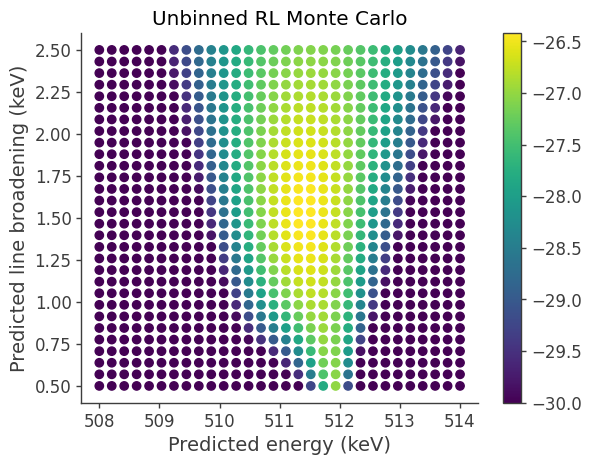

In [210]:
plt.scatter(pred_mu, pred_sigma, c=loglikes, vmin=-30)
plt.xlabel('Predicted energy (keV)')
plt.ylabel('Predicted line broadening (keV)')
plt.title('Unbinned RL Monte Carlo')
plt.colorbar()
plt.show()

### Setting up HealpixBase

In [5]:
mEq = HealpixBase(order=6, scheme='ring')

In [6]:
mEq.order, mEq.nside, mEq.npix

(6, 64, 49152)

In [7]:
theta0 = np.deg2rad(90)
phi0 = np.deg2rad(45)
sigma = np.deg2rad(1)        # Gaussian on sphere with 1-sigma width = 1 deg
disc_pix = mEq.query_disc(hmap.ang2vec(theta0, phi0), 3*sigma)

In [8]:
disc_pix

array([23200, 23455, 23456, 23711, 23712, 23713, 23966, 23967, 23968,
       23969, 24222, 24223, 24224, 24225, 24226, 24478, 24479, 24480,
       24481, 24734, 24735, 24736, 24737, 24738, 24990, 24991, 24992,
       24993, 25247, 25248, 25249, 25503, 25504, 25760])

In [9]:
m = HealpixMap.moc_from_pixels(mEq.nside, disc_pix, density=True)

print("NUNIQ pixels in MOC map: {}".format(m.npix))
print("Equivalent single-resolution pixels: {}".format(mEq.npix))

# Fill the map. This code would look exactly the same if this were a
# single-resolution map
for pix in range(m.npix):

    theta,phi = m.pix2ang(pix)

    m[pix] = np.exp(-((theta-theta0)**2 + (phi-phi0)**2) / 2 / sigma**2)

NUNIQ pixels in MOC map: 114
Equivalent single-resolution pixels: 49152


In [10]:
m.write_map('example.fits')

In [ ]:
def fits_to_h5(fits_file, h5_file):
    with fits.open(fits_file) as hdul:
        header0 = hdul[0].header
        header1 = hdul[1].header
        
        with h5py.File(h5_file, 'w') as hdf:
            hdf.create_group('header0')
            for key, value in header0.items():
                hdf['header0'].attrs[key] = value
            
            hdf.create_group('header1')
            for key, value in header1.items():
                hdf['header1'].attrs[key] = value
            
            data = hdul[1].data
            dset = hdf.create_dataset('data', data=data)

# Example usage
fits_to_h5('example.fits', 'example.h5')


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                  114 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'UNIQ    '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'CONTENTS'                                                            
TFORM2  = 'D       '                                                            
PIXTYPE = 'HEALPIX '        

In [13]:
FullDetectorResponse.open('example.fits')

ValueError: Unsupported file format. Only .h5 and .rsp.gz extensions are supported.

In [4]:
h5py.File('example.h5', mode='r')

OSError: Unable to synchronously open file (file signature not found)

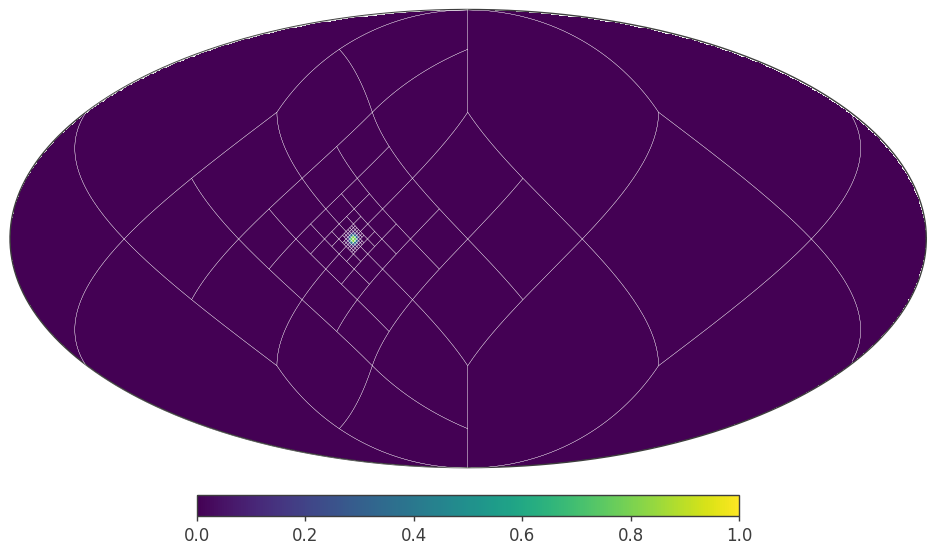

In [49]:
fig = plt.figure(figsize=(14, 7))
axMoll = fig.add_subplot(projection = "mollview")
m.plot(axMoll, vmin=0, vmax=1)
m.plot_grid(axMoll, color='white', linewidth = .2)
plt.show()

In [11]:
with FullDetectorResponse.open('transformed_response_example.h5') as response:
    print(response['DRM'])

KeyError: "Unable to synchronously open attribute (can't locate attribute: 'UNIT')"